In [700]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, classification_report, roc_curve, f1_score, log_loss

#### EDA
---

In [438]:
df = pd.read_csv("bank.csv", sep=';')

In [440]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [442]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


как видим, в данных отсутствуют пропуски вообще

In [447]:
df['poutcome'].value_counts()

poutcome
unknown    3705
failure     490
other       197
success     129
Name: count, dtype: int64

Преобразуем категориальные переменные в числовые

In [450]:
df['y'] = df['y'].map({'no':0, 'yes':1})

In [452]:
df['poutcome'] = df['poutcome'].apply(lambda x: 1 if x == 'success' else 0)

In [454]:
df['default'] = df['default'].map({"no":0, "yes":1})

In [456]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   int64 
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   int64 
 16  y          4521 non-null   int64 
dtypes: int64(10), object(7)
memory usage: 600.6+ KB


In [458]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

____
### Проверим, как распределены поля default, возраст, образование и другие признаки в датасете

* Таргет

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120')])

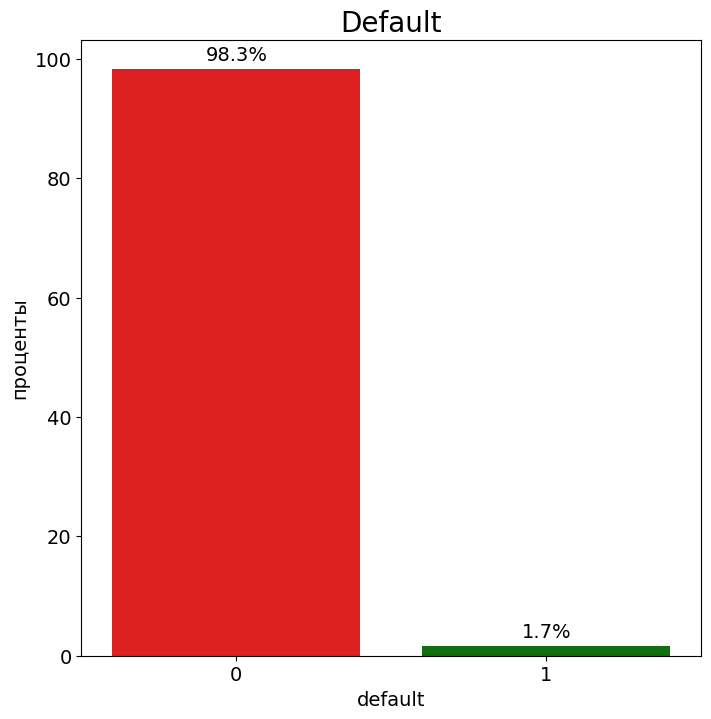

In [462]:
normalized_target = (df['default'].value_counts(normalize=True).mul(100).rename('percent').reset_index())
plt.figure(figsize=(8,8))
ax = sns.barplot(x='default', y='percent', data=normalized_target, palette=['red', 'green'])

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()), # координата (x, y)
                ha='center',
                va='center',
                xytext=(0,10),
                textcoords='offset points', # точка смещения относительно координаты
                fontsize=14)
plt.title('Default', fontsize=20)
plt.xlabel('default', fontsize=14)
plt.ylabel('проценты', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

---
ясно видно, что в датасете присутствует дисбаланс классов. в дальнейшем учтем это
___

* Возраст

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.01, '0.01'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.03, '0.03'),
  Text(0, 0.04, '0.04'),
  Text(0, 0.05, '0.05')])

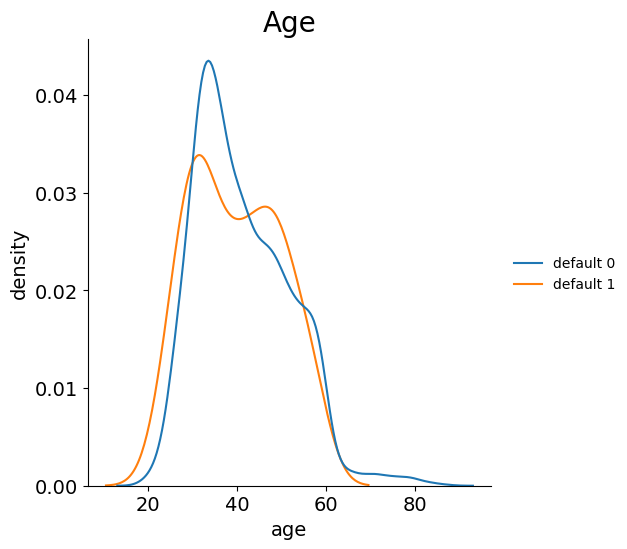

In [466]:
sns.displot(
    {
        "default 0": df[df['default'] == 0]['age'],
        "default 1": df[df['default'] == 1]['age']
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
           )
plt.title('Age', fontsize=20)
plt.xlabel('age', fontsize=14)
plt.ylabel('density', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

по графику видно, что разница в возрасте присутствует. подтвердим или опровергнем это через медиану, моду и среднее

In [469]:
df.groupby('default')['age'].median()

default
0    39.0
1    39.0
Name: age, dtype: float64

# df.groupby('default')['age'].mean()

In [472]:
df.groupby('default')['age'].apply(lambda x: x.mode())

default   
0        0    34
1        0    32
Name: age, dtype: int64

In [474]:
df.groupby('default')['age'].apply(lambda x: x.mode())df.groupby('default')['age'].agg(pd.Series.mode) # то же самое что и df.groupby('default')['age'].apply(lambda x: x.mode())

SyntaxError: invalid syntax (1296113013.py, line 1)

* Образование

In [477]:
df['education'].value_counts()

education
secondary    2306
tertiary     1350
primary       678
unknown       187
Name: count, dtype: int64

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.01, '0.01'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.03, '0.03'),
  Text(0, 0.04, '0.04'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.06, '0.06')])

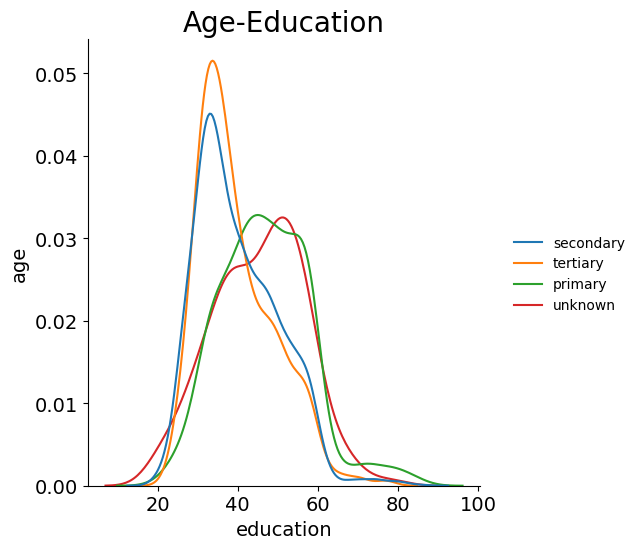

In [479]:
sns.displot(
    {
        "secondary": df[df['education'] == 'secondary']['age'],
        "tertiary": df[df['education'] == 'tertiary']['age'],
        "primary": df[df['education'] == 'primary']['age'],
        "unknown": df[df['education'] == 'unknown']['age']
    },
    kind="kde",
    common_norm=False
)
plt.title("Age-Education", fontsize=20)
plt.xlabel("education", fontsize=14)
plt.ylabel("age", fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 [Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60'),
  Text(0, 70.0, '70'),
  Text(0, 80.0, '80'),
  Text(0, 90.0, '90'),
  Text(0, 100.0, '100')])

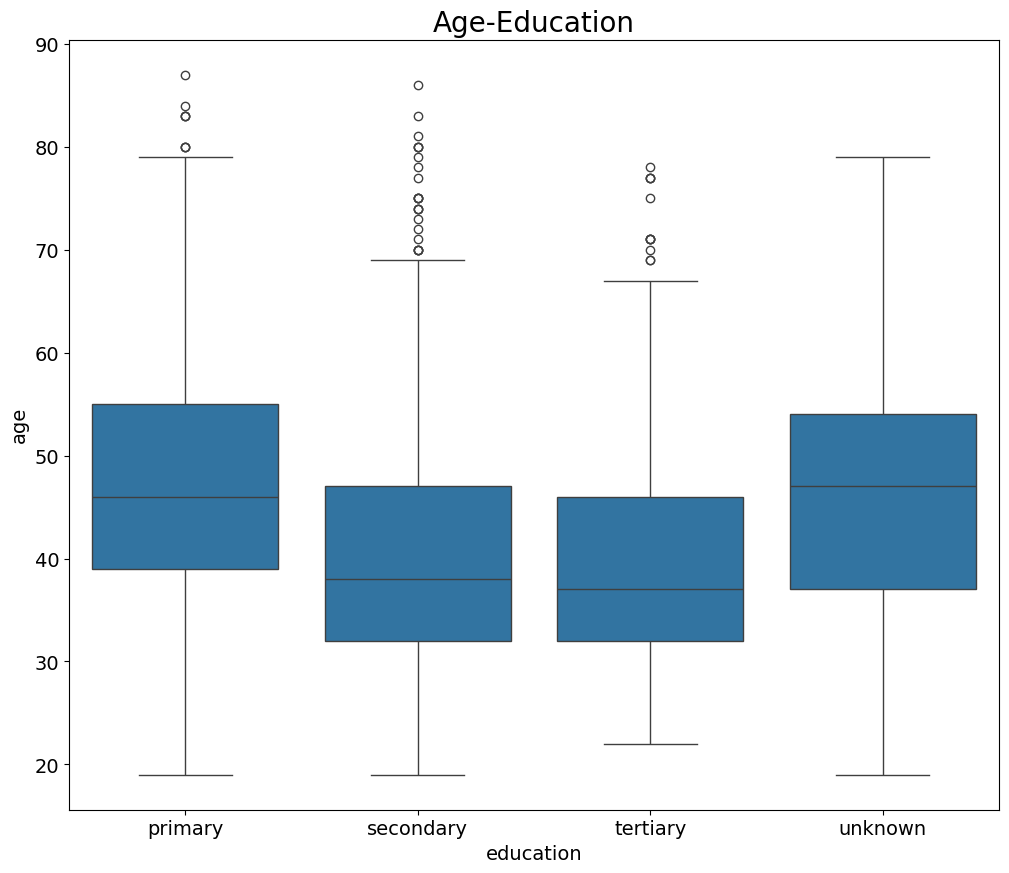

In [480]:
plt.figure(figsize=(12,10))

sns.boxplot(x='education', y='age', data=df)

plt.title("Age-Education", fontsize=20)
plt.xlabel("education", fontsize=14)
plt.ylabel("age", fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 [Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60'),
  Text(0, 70.0, '70'),
  Text(0, 80.0, '80'),
  Text(0, 90.0, '90'),
  Text(0, 100.0, '100')])

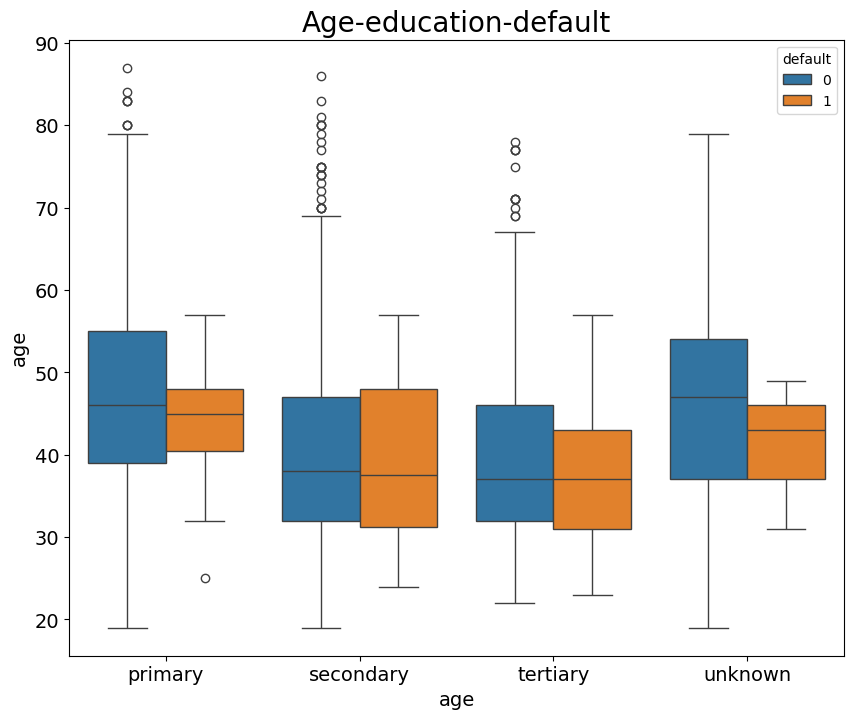

In [483]:
plt.figure(figsize=(10, 8))

sns.boxplot(x='education', y='age', hue='default', data=df)

plt.title('Age-education-default', fontsize=20)
plt.ylabel('age', fontsize=14)
plt.xlabel('age', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 [Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60'),
  Text(0, 70.0, '70')])

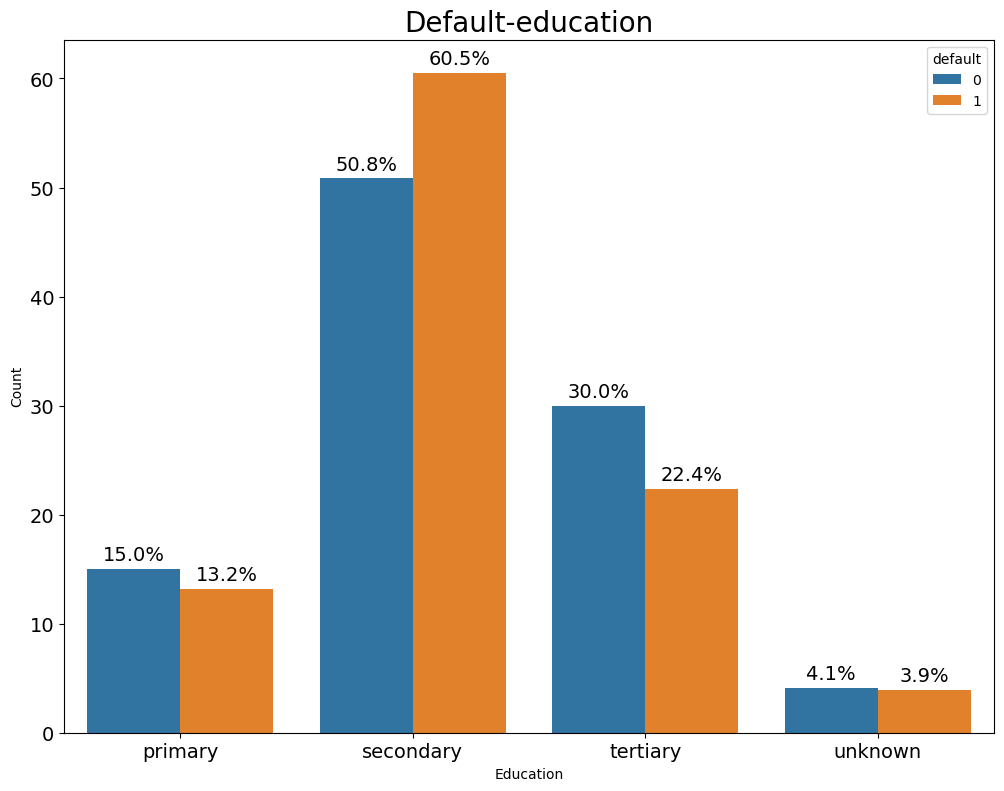

In [484]:
plt.figure(figsize=(12, 9))

educ_def = df.groupby(['default'])['education'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('education')
educ_def = educ_def[educ_def['percentage'] > 0]
ax = sns.barplot(x='education', y='percentage', hue='default', data=educ_def)

for p in ax.patches:
    if p.get_height() > 0: # чтобы не было странной записи около primary
        percentage =  '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage, # текст (вывод процентов)
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # координатa (x, y)
                     ha='center',
                     va='center',
                     xytext=(0, 10),
                     textcoords='offset points', # точка смещения относительно координаты
                     fontsize=14)
plt.title("Default-education", fontsize=20)
plt.ylabel("Count")
plt.xlabel("Education")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

* Корреляция в данных 

<Axes: >

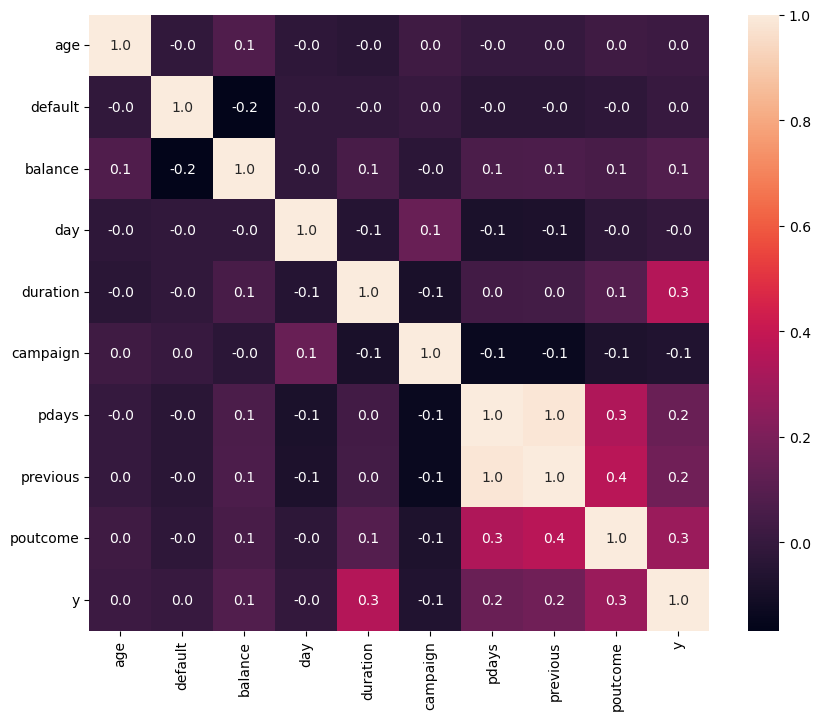

In [488]:
plt.figure(figsize=(10, 8))

sns.heatmap(df[df.columns].corr(method='spearman', numeric_only=True), annot=True, fmt=".1f")

Как видим, pdays и previous очень сильно коллерируют между собой -> удалим признак pdays 

In [491]:
df = df.drop(columns=['pdays'])

In [493]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'previous',
       'poutcome', 'y'],
      dtype='object')

* Анализ зарплат 

(array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012]),
 [Text(0, 0.0, '0.0000'),
  Text(0, 0.0002, '0.0002'),
  Text(0, 0.0004, '0.0004'),
  Text(0, 0.0006000000000000001, '0.0006'),
  Text(0, 0.0008, '0.0008'),
  Text(0, 0.001, '0.0010'),
  Text(0, 0.0012000000000000001, '0.0012')])

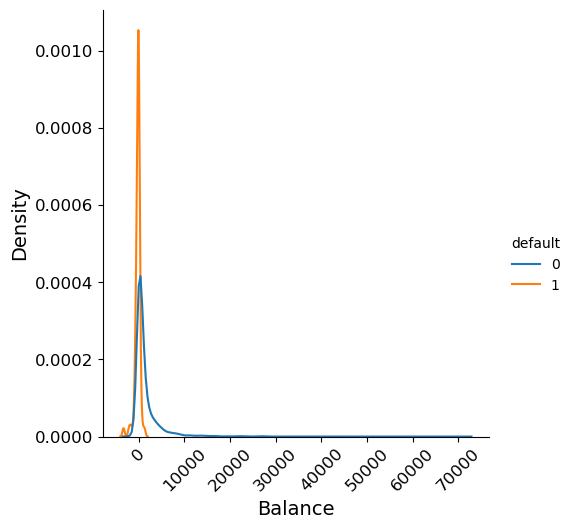

In [496]:
sns.displot(df, x='balance', hue='default', kind='kde', common_norm=False)

plt.xlabel("Balance", fontsize=14)
plt.ylabel("Density", fontsize=14)

plt.xticks(fontsize=12, rotation=45)  # поворот подписей для лучшей читаемости
plt.yticks(fontsize=12)

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.]),
 [Text(0, -10000.0, '−10000'),
  Text(0, 0.0, '0'),
  Text(0, 10000.0, '10000'),
  Text(0, 20000.0, '20000'),
  Text(0, 30000.0, '30000'),
  Text(0, 40000.0, '40000'),
  Text(0, 50000.0, '50000'),
  Text(0, 60000.0, '60000'),
  Text(0, 70000.0, '70000'),
  Text(0, 80000.0, '80000')])

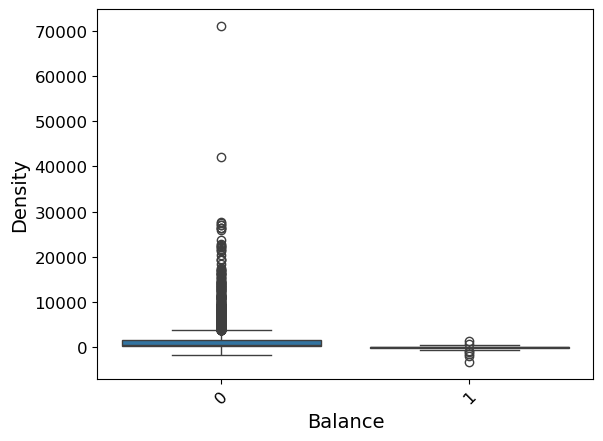

In [498]:
sns.boxplot(data=df, x='default', y='balance')

plt.xlabel("Balance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=12, rotation=45)  # поворот подписей для лучшей читаемости
plt.yticks(fontsize=12)

Видим очень много выбросов -> смотрим на разницу в средних 

In [501]:
df.groupby('default')['balance'].mean()

default
0    1450.550956
1    -208.723684
Name: balance, dtype: float64

In [503]:
df.groupby('default')['balance'].median()

default
0    462.0
1    -19.0
Name: balance, dtype: float64

In [505]:
df.groupby('default')['balance'].apply(lambda x: x.mode())

default   
0        0    0
1        0    0
Name: balance, dtype: int64

Поскольку данные имеют ненормальное распределение, логарифмируем их

In [576]:
def normal_val(val):
    if val > 0:
        return val
    return 1

tmp_df = df.copy()
tmp_df['balance'] = np.log(df['balance'].apply(lambda x: normal_val(x)))
tmp_df['balance']

0       7.488294
1       8.474077
2       7.207860
3       7.297091
4       0.000000
          ...   
4516    0.000000
4517    0.000000
4518    5.686975
4519    7.036148
4520    7.035269
Name: balance, Length: 4521, dtype: float64

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.01, '0.01'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.03, '0.03'),
  Text(0, 0.04, '0.04'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.06, '0.06')])

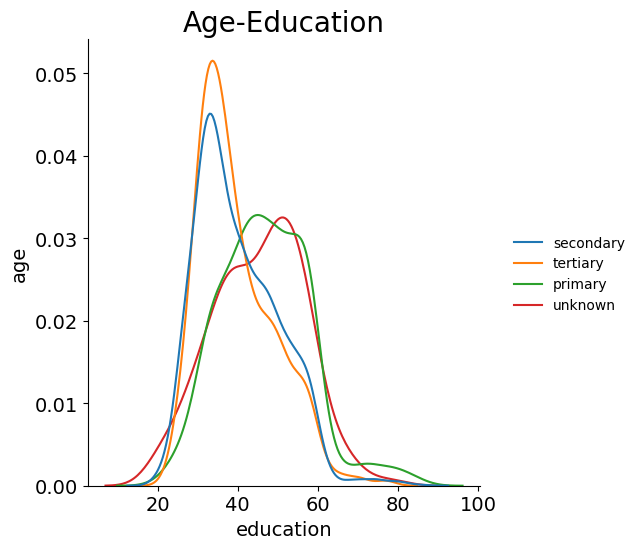

In [510]:
sns.displot(
    {
        "secondary": tmp_df[tmp_df['education'] == 'secondary']['age'],
        "tertiary": tmp_df[tmp_df['education'] == 'tertiary']['age'],
        "primary": tmp_df[tmp_df['education'] == 'primary']['age'],
        "unknown": tmp_df[tmp_df['education'] == 'unknown']['age']
    },
    kind="kde",
    common_norm=False
)
plt.title("Age-Education", fontsize=20)
plt.xlabel("education", fontsize=14)
plt.ylabel("age", fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

___
# Feature engineering

In [544]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
0,30,unemployed,2,1,0,1787,0,1,cellular,19,oct,79,1,0,0,0
1,33,services,2,2,0,4789,1,0,cellular,11,may,220,1,4,0,0
2,35,management,1,3,0,1350,1,1,cellular,16,apr,185,1,1,0,0
3,30,management,2,3,0,1476,1,0,unknown,3,jun,199,4,0,0,0
4,59,blue-collar,2,2,0,0,1,1,unknown,5,may,226,1,0,0,0


In [546]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   int64 
 3   education  4521 non-null   int64 
 4   default    4521 non-null   int64 
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   int64 
 7   loan       4521 non-null   int64 
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  previous   4521 non-null   int64 
 14  poutcome   4521 non-null   int64 
 15  y          4521 non-null   int64 
dtypes: int64(13), object(3)
memory usage: 565.3+ KB


Заменим категориальные признаки на числовые

In [517]:
df['education'] = df['education'].replace(
    {
        "primary": 1,
        "secondary": 2,
        "tertiary": 3,
        "unknown": 0
    }
)

In [530]:
df['marital'] = df['marital'].replace(
    {
        "married":2,
        "single":1,
        "divorced":0
    }
)

In [534]:
df['housing'] = df['housing'].replace(
    {
        "no": 0,
        "yes": 1
    }
)

In [538]:
df['loan'] = df['loan'].replace(
    {
        "no": 1,
        "yes": 0
    }
)

In [553]:
num_cols = ['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'duration', 'campaign', 'previous', 'poutcome', 'y']   

In [555]:
df['poutcome'].value_counts()

poutcome
0    4392
1     129
Name: count, dtype: int64

In [567]:
numeric_features = df[num_cols]
numeric_features

,age,marital,education,default,balance,housing,loan,duration,campaign,previous,poutcome,y
0,30,2,1,0,1787,0,1,79,1,0,0,0
1,33,2,2,0,4789,1,0,220,1,4,0,0
2,35,1,3,0,1350,1,1,185,1,1,0,0
3,30,2,3,0,1476,1,0,199,4,0,0,0
4,59,2,2,0,0,1,1,226,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,2,2,0,-333,1,1,329,5,0,0,0
4517,57,2,3,1,-3313,1,0,153,1,0,0,0
4518,57,2,2,0,295,0,1,151,11,0,0,0
4519,28,2,2,0,1137,0,1,129,4,3,0,0


In [571]:
numeric_features = numeric_features.stack().reset_index().rename(
        columns={"level_1":"Features", 0:"Value"})

Text(0.5, 0.98, 'Гистограмма разнообразных фичей')

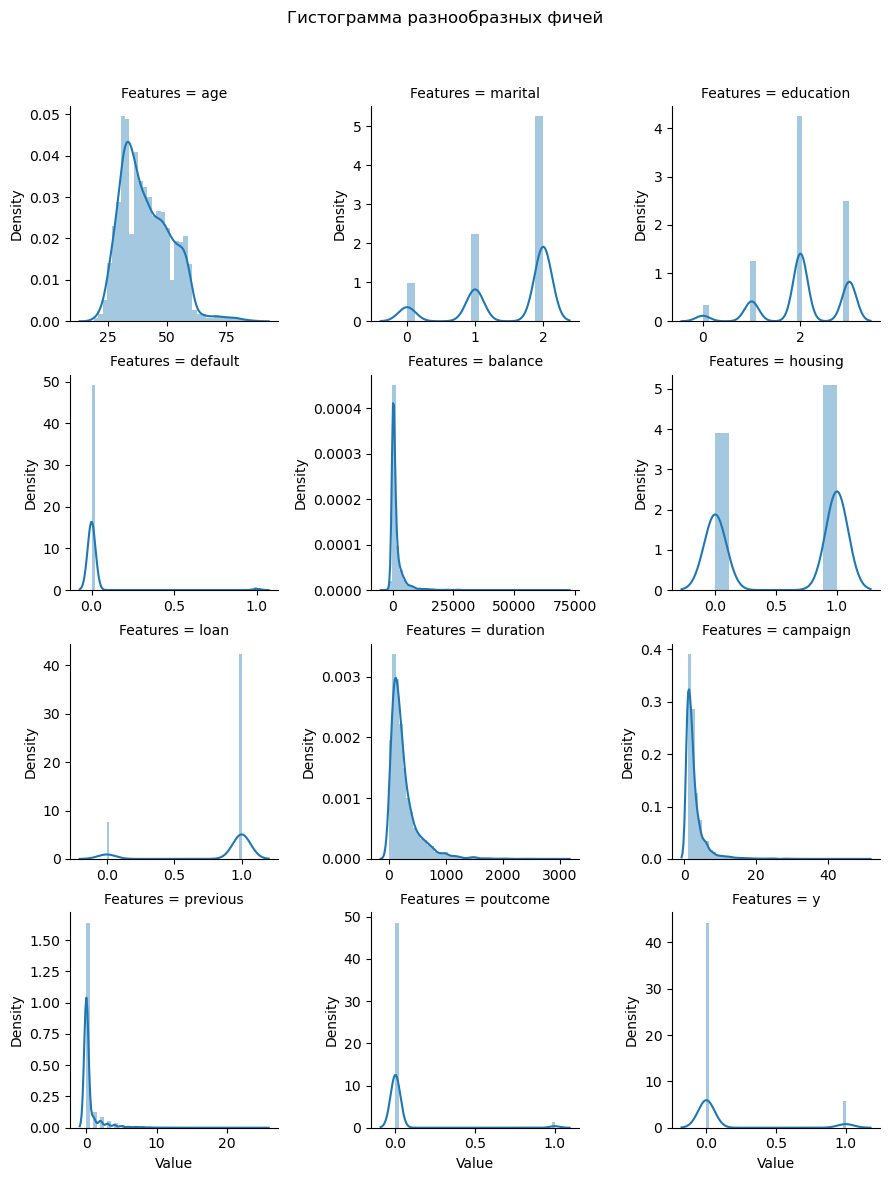

In [573]:
ax = sns.FacetGrid(data=numeric_features, col='Features', col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Гистограмма разнообразных фичей")

Видим, что некоторые фичи распределены ненормально - попробуем их нормализовать 

In [582]:
for i in ['age', 'balance', 'duration', 'campaign', 'previous']:
    df[i] = np.log(df[i].apply(lambda x: normal_val(x)))

Взглянем на графики после этих преобразований 

Text(0.5, 0.98, 'Гистограмма разнообразных фичей')

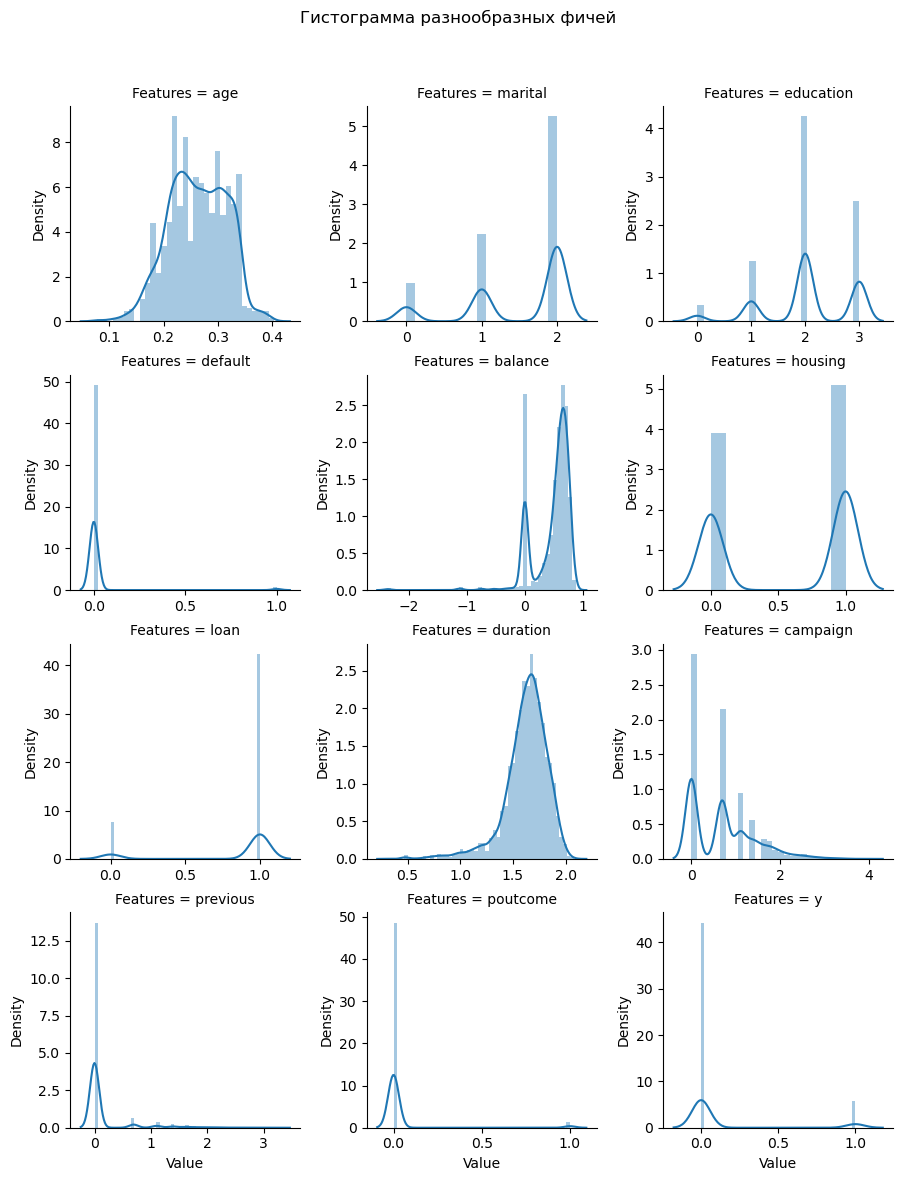

In [585]:
numeric_features = df[num_cols]
numeric_features
numeric_features = numeric_features.stack().reset_index().rename(
        columns={"level_1":"Features", 0:"Value"})
ax = sns.FacetGrid(data=numeric_features, col='Features', col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Гистограмма разнообразных фичей")

* Создадим новый признак - средний доход по рабочему месту

In [588]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
0,0.202228,unemployed,2,1,0,0.699795,0,1,cellular,19,oct,1.474637,0.000000,0.000000,0,0
1,0.224554,services,2,2,0,0.759408,1,0,cellular,11,may,1.685218,0.000000,1.386294,0,0
2,0.237798,management,1,3,0,0.680656,1,1,cellular,16,apr,1.652566,0.000000,0.000000,0,0
3,0.202228,management,2,3,0,0.686865,1,0,unknown,3,jun,1.666443,1.386294,0.000000,0,0
4,0.340388,blue-collar,2,2,0,0.000000,1,1,unknown,5,may,1.690195,0.000000,0.000000,0,0


In [608]:
mean_balance_by_workplace = df.groupby('job')['balance'].mean().to_dict()
df['mean_balance_by_workplace'] = df['job'].map(mean_balance_by_workplace)

In [628]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,mean_balance_by_workplace,y
0,0.202228,unemployed,2,1,0,0.699795,0,1,cellular,19,oct,1.474637,0.000000,0.000000,0,0.467344,0
1,0.224554,services,2,2,0,0.759408,1,0,cellular,11,may,1.685218,0.000000,1.386294,0,0.435451,0
2,0.237798,management,1,3,0,0.680656,1,1,cellular,16,apr,1.652566,0.000000,0.000000,0,0.502605,0
3,0.202228,management,2,3,0,0.686865,1,0,unknown,3,jun,1.666443,1.386294,0.000000,0,0.502605,0
4,0.340388,blue-collar,2,2,0,0.000000,1,1,unknown,5,may,1.690195,0.000000,0.000000,0,0.463859,0


In [620]:
df['mean_balance_by_workplace'].value_counts()

mean_balance_by_workplace
0.502605    969
0.463859    946
0.467316    768
0.462089    478
0.435451    417
0.532620    230
0.517952    183
0.466984    168
0.467344    128
0.441642    112
0.454832     84
0.560930     38
Name: count, dtype: int64

In [658]:
df.head()

,age,marital,education,default,balance,housing,loan,contact,day,duration,campaign,previous,poutcome,mean_balance_by_workplace,y
0,0.202228,2,1,0,0.699795,0,1,1,19,1.474637,0.000000,0.000000,0,0.467344,0
1,0.224554,2,2,0,0.759408,1,0,1,11,1.685218,0.000000,1.386294,0,0.435451,0
2,0.237798,1,3,0,0.680656,1,1,1,16,1.652566,0.000000,0.000000,0,0.502605,0
3,0.202228,2,3,0,0.686865,1,0,0,3,1.666443,1.386294,0.000000,0,0.502605,0
4,0.340388,2,2,0,0.000000,1,1,0,5,1.690195,0.000000,0.000000,0,0.463859,0


In [656]:
df = df.drop(columns='job')

In [645]:
df['contact'] = df['contact'].replace(
    {
        "cellular": 1, 
        "telephone": 1,
        "unknown":0
    }
)

In [626]:
df = df[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'previous',
       'poutcome', 'mean_balance_by_workplace', 'y']]

---
## Создание и обучение модели

In [675]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, stratify=df['default'], shuffle=True, random_state=42)

### Baseline

In [726]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

In [702]:
print('ROC-AUC:', roc_auc_score(y_test, y_proba))  
print('Precision:', precision_score(y_test, y_pred)) 
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred)) 
print('Log Loss:', log_loss(y_test, y_pred)) 

ROC-AUC: 0.8653095238095239
Precision: 0.32432432432432434
Recall: 0.8
F1-score: 0.46153846153846156
Log Loss: 7.806139297532555


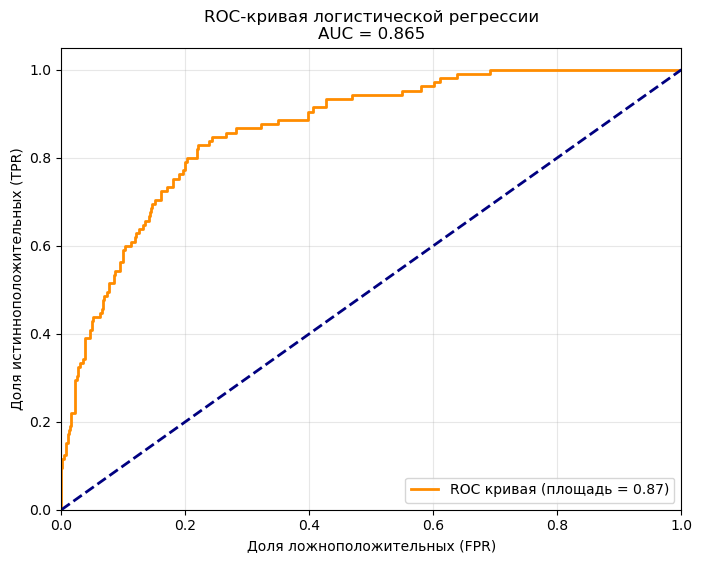

In [706]:
# показатели для ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# вычисляем площадь под кривой (AUC)
roc_auc = auc(fpr, tpr)

#  график ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC кривая (площадь = {roc_auc:.2f})')

#  диагональ случайной модели
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложноположительных (FPR)')
plt.ylabel('Доля истинноположительных (TPR)')
plt.title('ROC-кривая логистической регрессии\nAUC = %.3f' % roc_auc)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()

### Подбор гиперпараметров 

In [715]:
param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    'C': np.linspace(1, 1000, num=5),
    'solver': ['sag', 'saga', 'lbfgs'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': np.arange(100,500,100)
}

lr = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=cv, verbose=2)

In [717]:
# обучаем по сетке для нахождения наилучших гиперпараметров
grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, pe

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': array([   1.  ,  250.75,  500.5 ,  750.25, 1000.  ]),
                         'l1_ratio': [0.25, 0.5, 0.75],
                         'max_iter': array([100, 200, 300, 400]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['sag', 'saga', 'lbfgs']},
             scoring='roc_auc', verbose=2)

In [719]:
grid_cv.best_params_

{'C': 250.75,
 'l1_ratio': 0.25,
 'max_iter': 300,
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [728]:
best_model = grid_cv.best_estimator_
y_pred2 = best_model.predict(X_test)
y_proba2 = best_model.predict_proba(X_test)[:, 1]

In [730]:
print('ROC-AUC:', roc_auc_score(y_test, y_proba2))  
print('Precision:', precision_score(y_test, y_pred2)) 
print('Recall:', recall_score(y_test, y_pred2))
print('F1-score:', f1_score(y_test, y_pred2)) 
print('Log Loss:', log_loss(y_test, y_pred2)) 

ROC-AUC: 0.8634642857142856
Precision: 0.3346613545816733
Recall: 0.8
F1-score: 0.47191011235955055
Log Loss: 7.487521367021022


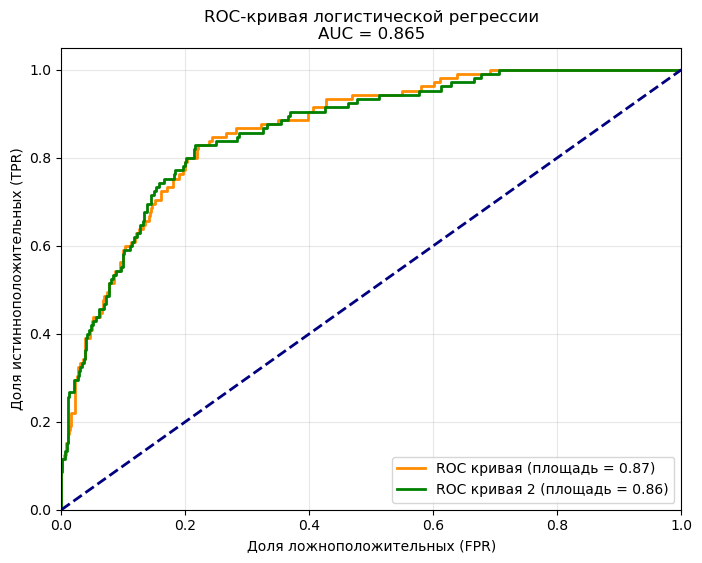

In [734]:
# показатели для ROC-кривой
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_proba2)

# вычисляем площадь под кривой (AUC)
roc_auc2 = auc(fpr2, tpr2)

#  график ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC кривая (площадь = {roc_auc:.2f})')
plt.plot(fpr2, tpr2, color='green', lw=2, 
         label=f'ROC кривая 2 (площадь = {roc_auc2:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложноположительных (FPR)')
plt.ylabel('Доля истинноположительных (TPR)')
plt.title('ROC-кривая логистической регрессии\nAUC = %.3f' % roc_auc)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()